In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import pickle

# Read the dataset

In [2]:
df = pd.read_csv('datasets/cleaned_datasets/cleaned-linen-data.csv')
df.head()

,review,label
0,harga rupa makan pagi snack kurang air panas f...,pos
1,bantal enak kamar dingin keset nha,pos
2,tampil kamar luas bed empuk fasilitas lengkap ...,pos
3,kamar jangkau sedia snack makan pagi kamar bau...,pos
4,good snack kamar sayang pas kamar ac nya dingi...,pos


# Split dataset 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

# Menampilkan hasil
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (238,)
X_test shape: (60,)
y_train shape: (238,)
y_test shape: (60,)


# TF-IDF 

In [4]:
# Inisialisasi objek stopword remover
stopword_factory = StopWordRemoverFactory()
stopwords = stopword_factory.get_stop_words()

# tf_idf model
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords)

# menghitung nilai tf-idf
train_tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
test_tfidf_matrix = tfidf_vectorizer.transform(X_test)

# Menampilkan hasil
print(train_tfidf_matrix.shape)
print(test_tfidf_matrix.shape)

(238, 1479)
(60, 1479)


# Smote

In [5]:
# Train
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(train_tfidf_matrix, y_train)
X_test_resampled, y_test_resampled = SMOTE(random_state=42).fit_resample(test_tfidf_matrix, y_test)

# Menampilkan hasil
print("X_train_resampled shape:", X_train_resampled.shape)
print("X_test_resampled shape:", X_test_resampled.shape)
print("y_train y_train_resampled:", y_train_resampled.shape)
print("y_test_resampled shape:", y_test_resampled.shape)

X_train_resampled shape: (246, 1479)
X_test_resampled shape: (68, 1479)
y_train y_train_resampled: (246,)
y_test_resampled shape: (68,)


# Naive Bayes

In [6]:
# parameter tuning
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

# Mendapatkan parameter terbaik
best_alpha = grid_search.best_params_['alpha']
print(best_alpha)

0.1


In [7]:
nb = MultinomialNB(alpha=best_alpha)
nb.fit(X_train_resampled, y_train_resampled)

y_pred = nb.predict(X_test_resampled)

print('Accuracy score : ', accuracy_score(y_test_resampled, y_pred))
print('Precision score : ', precision_score(y_test_resampled, y_pred, average='weighted'))
print('Recall score : ', recall_score(y_test_resampled, y_pred, average='weighted'))
print('F1 score : ', f1_score(y_test_resampled, y_pred, average='weighted'))

Accuracy score :  0.8823529411764706
Precision score :  0.8836805555555556
Recall score :  0.8823529411764706
F1 score :  0.8822510822510822


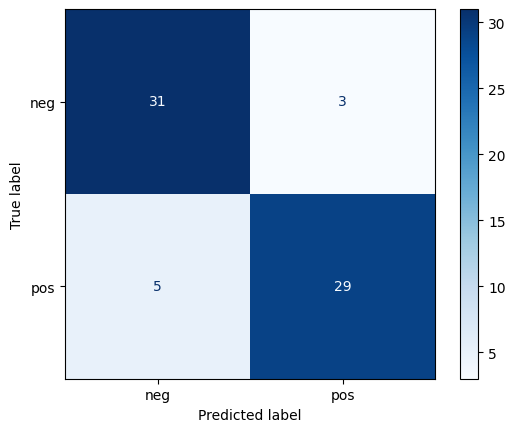

In [8]:
ConfusionMatrixDisplay.from_predictions(y_test_resampled, y_pred, cmap='Blues')
plt.show()

In [9]:
print(classification_report(y_test_resampled, y_pred))

              precision    recall  f1-score   support

         neg       0.86      0.91      0.89        34
         pos       0.91      0.85      0.88        34

    accuracy                           0.88        68
   macro avg       0.88      0.88      0.88        68
weighted avg       0.88      0.88      0.88        68



In [10]:
with open('trained_model/nb_classifier_linen.pkl', 'wb') as f:
    pickle.dump(nb, f)